# FashionMNIST Classification using ViT

In [27]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"  # Ensure TensorFlow backend is used

import tensorflow as tf
import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist

# Load FashionMNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (60000, 28, 28) - y_train shape: (60000,)
x_test shape: (10000, 28, 28) - y_test shape: (10000,)


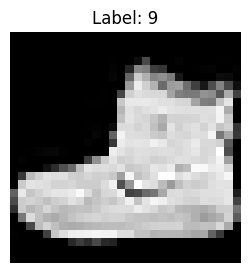

In [28]:
# Plot one image from the dataset
plt.figure(figsize=(3, 3))
plt.imshow(x_train[0], cmap='gray')
plt.title(f"Label: {y_train[0]}")
plt.axis('off')
plt.show()

In [29]:
# Configure the hyperparameters
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 20
image_size = 28  # FashionMNIST images are 28x28
patch_size = 4
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 6
mlp_head_units = [
    512,
    256,
]

In [30]:
# Use data augmentation
data_augmentation = keras.Sequential(
    [
        layers.Rescaling(scale=1.0 / 255),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)



In [31]:
# Implement multilayer perceptron (MLP)
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation="relu")(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# Implement patch creation as a layer
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

# Implement the patch encoding layer
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

# Build the ViT model
def create_vit_classifier():
    inputs = layers.Input(shape=(image_size, image_size, 1))
    augmented = data_augmentation(inputs)
    patches = Patches(patch_size)(augmented)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block
    for _ in range(transformer_layers):
        # Layer normalization 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Multi-head self-attention
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2
        encoded_patches = layers.Add()([x3, x2])

    # Apply global average pooling to get one vector per image
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.GlobalAveragePooling1D()(representation)
    # Apply MLP head to generate final class predictions
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    logits = layers.Dense(10, activation="softmax")(features)

    model = keras.Model(inputs=inputs, outputs=logits)
    return model



In [32]:
# Compile, train, and evaluate the model
def run_experiment(model):
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    checkpoint_filepath = "/kaggle/working/model.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history

Epoch 1/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 31s 67ms/step - accuracy: 0.3903 - loss: 1.5495 - val_accuracy: 0.6872 - val_loss: 0.8158
Epoch 2/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 13s 63ms/step - accuracy: 0.6733 - loss: 0.8486 - val_accuracy: 0.7425 - val_loss: 0.6574
Epoch 3/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 13s 63ms/step - accuracy: 0.7305 - loss: 0.7087 - val_accuracy: 0.7633 - val_loss: 0.6323
Epoch 4/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 13s 63ms/step - accuracy: 0.7535 - loss: 0.6581 - val_accuracy: 0.7848 - val_loss: 0.5650
Epoch 5/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - accuracy: 0.7623 - loss: 0.6313 - val_accuracy: 0.7835 - val_loss: 0.5663
Epoch 6/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - accuracy: 0.7687 - loss: 0.6116 - val_accuracy: 0.7785 - val_loss: 0.5784
Epoch 7/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 13s 63ms/step - accuracy: 0.7771 - loss: 0.5903 - val_accuracy: 0.8053 - val_loss: 0.5289
Epoch 8/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - accuracy: 0.7849 - loss: 0.5744 - 

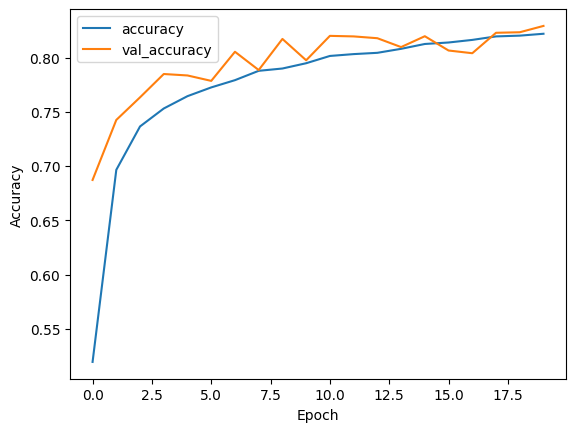

In [33]:
# Create and run the ViT model
vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

# Plot history
def plot_history(history):
    plt.plot(history.history["accuracy"], label="accuracy")
    plt.plot(history.history["val_accuracy"], label="val_accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

plot_history(history)

In [34]:
# Evaluate the model on the test dataset
_, test_accuracy = vit_classifier.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8293 - loss: 0.4599
Test accuracy: 82.98%


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


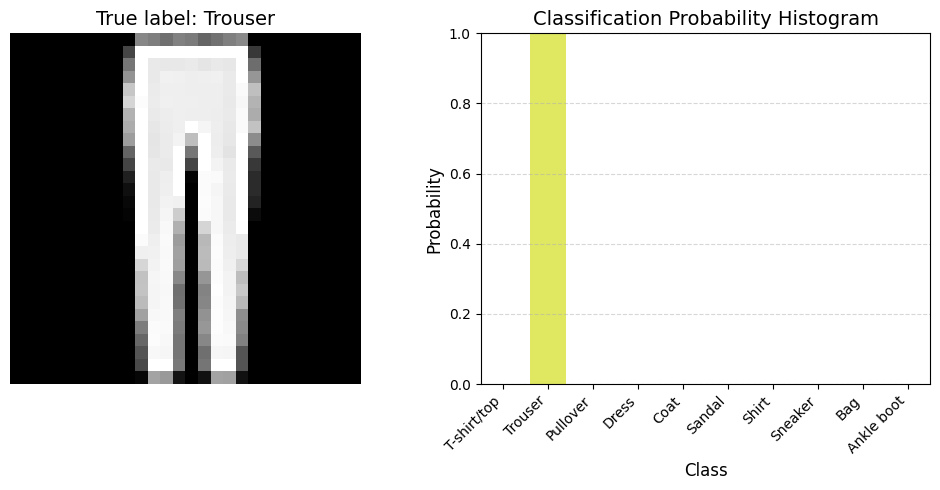

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


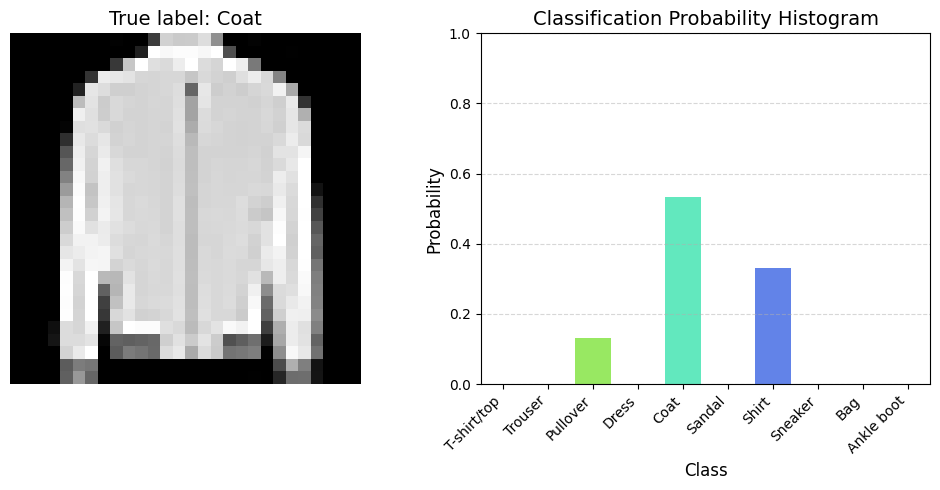

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


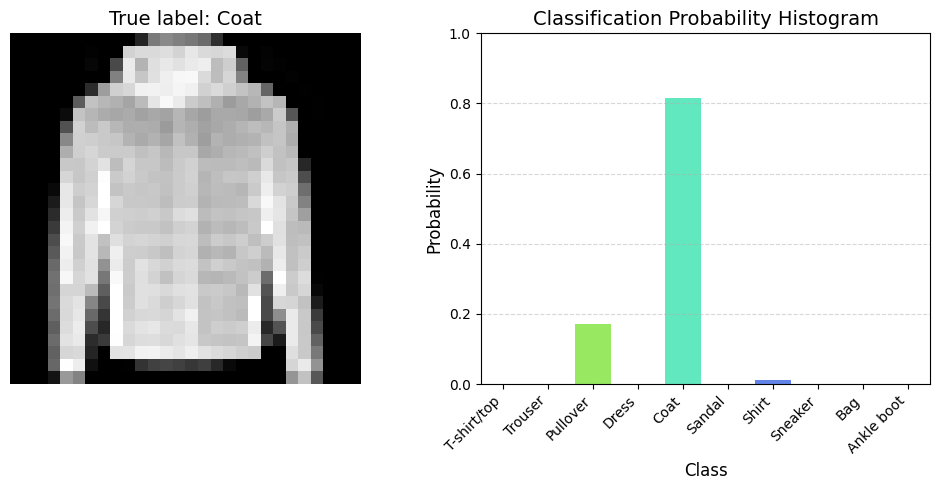

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


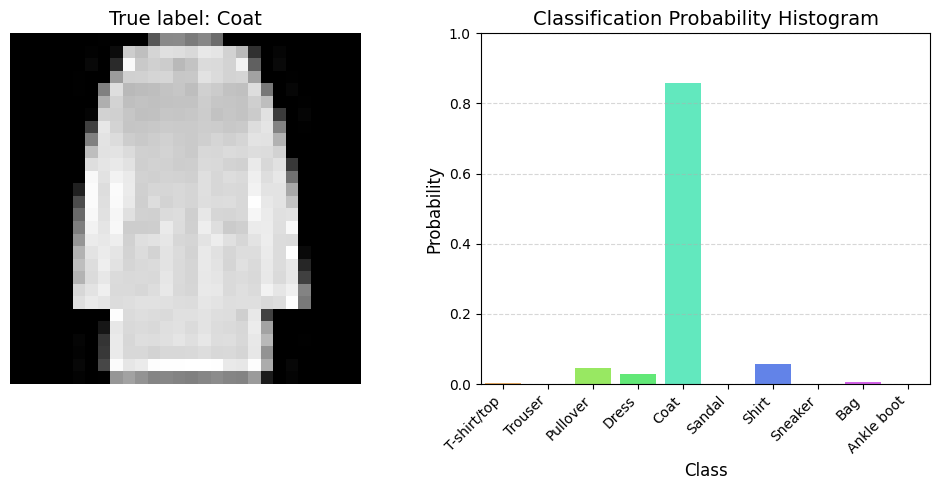

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


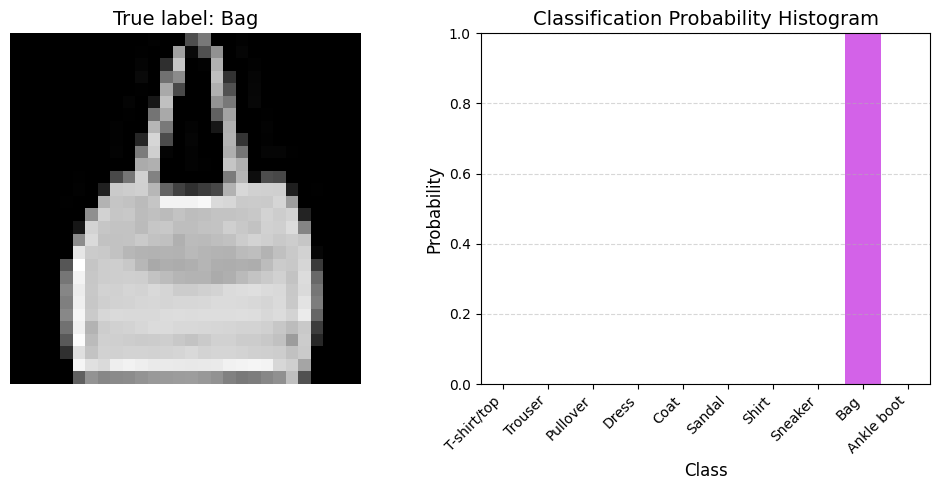

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

num_classes = len(class_names)
# Predict probabilities for each class
predictions = vit_classifier.predict(x_test)

# Define a color palette for different classes
palette = sns.color_palette("hsv", num_classes)

# Function to plot image and classification probability histogram
def plot_sample(sample_index):
    plt.figure(figsize=(10, 5))

    # Plot the image
    plt.subplot(1, 2, 1)
    plt.imshow(x_test[sample_index], cmap='gray')
    plt.title(f"True label: {class_names[y_test[sample_index]]}", fontsize=14)
    plt.axis('off')

    # Plot the classification probability histogram using Seaborn
    plt.subplot(1, 2, 2)
    sns.barplot(x=class_names, y=predictions[sample_index], palette=palette, alpha=0.7)
    plt.xlabel('Class', fontsize=12)
    plt.ylabel('Probability', fontsize=12)
    plt.title('Classification Probability Histogram', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# Select a few random samples to plot
num_samples_to_plot = 5
random_sample_indices = np.random.choice(len(x_test), num_samples_to_plot, replace=False)

# Plot each selected sample
for index in random_sample_indices:
    plot_sample(index)